In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from datetime import datetime

import json
import requests

In [27]:
news_API_key = '' #INSERT NEWS API KEY
topic = 'ethereum'
topic_url = f'https://newsapi.org/v2/everything?q={topic}&apiKey={news_API_key}'

In [28]:
response = requests.get(topic_url)
all_data = response.json()
articles_data = all_data['articles']

In [29]:
df = pd.DataFrame(articles_data).drop(['author','url','urlToImage'], axis=1)

df['publishedAt'] =  df['publishedAt'].map(lambda x : datetime.strptime(x.split('T')[0], '%Y-%m-%d').date())
df = df.set_index('publishedAt').sort_index(ascending=False)
df['source'] = df['source'].map(lambda x : x['name'])
df = df.fillna('n/a')
df  =df.iloc[:5,:]

In [30]:
from finbert.finbert import predict # you could alternatively unpack this function into this notebook
from transformers import AutoModelForSequenceClassification

import nltk
# nltk.download('punkt')

model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert',num_labels=3,cache_dir=None)

In [31]:
df['title_sentiment'] = df['title'].map(lambda x : predict(x, model)['sentiment_score'][0] if x != 'n/a' else 0)
df['description_sentiment'] = df['description'].map(lambda x : predict(x, model)['sentiment_score'][0] if x != 'n/a' else 0)
df['content_sentiment'] = df['content'].map(lambda x : predict(x, model)['sentiment_score'][0] if x != 'n/a' else 0)
df.head()

,source,title,description,content,title_sentiment,description_sentiment,content_sentiment
publishedAt,,,,,,,
2021-09-25,BBC News,Music company buys NFT of 'Side-eyeing Chloe' ...,The image of two-year-old Chloe Clem making a ...,"image source, foundation.app/@SideEyeingChloe\...",0.145793,-0.183466,-0.678887
2021-09-24,The Verge,China’s central bank bans cryptocurrency trans...,China’s central bank on Friday said cryptocurr...,Its the countrys latest crackdown on digital c...,-0.515547,-0.728496,-0.743370
2021-09-22,Engadget,Robinhood will start testing crypto wallets ne...,Robinhood plans to start a cryptocurrency wall...,Robinhood plans to start a cryptocurrency wall...,0.050055,0.062854,0.062854
2021-09-22,Entrepreneur,Explore the Modern World of Cryptocurrency,"Start with the basics, then learn how to build...",The world is slowly but surely making a shift ...,0.034100,0.047500,0.212790
2021-09-21,Blogspot.com,Sorare raises $680 million for its fantasy spo...,image credit:SorareFrench startup Sorare has a...,image credit:Sorare\r\nFrench startup Sorare h...,0.669450,0.917961,0.911666


In [32]:
df['average_sentiment'] = df[['title_sentiment','description_sentiment','content_sentiment']].mean(axis=1)
df

,source,title,description,content,title_sentiment,description_sentiment,content_sentiment,average_sentiment
publishedAt,,,,,,,,
2021-09-25,BBC News,Music company buys NFT of 'Side-eyeing Chloe' ...,The image of two-year-old Chloe Clem making a ...,"image source, foundation.app/@SideEyeingChloe\...",0.145793,-0.183466,-0.678887,-0.238853
2021-09-24,The Verge,China’s central bank bans cryptocurrency trans...,China’s central bank on Friday said cryptocurr...,Its the countrys latest crackdown on digital c...,-0.515547,-0.728496,-0.743370,-0.662471
2021-09-22,Engadget,Robinhood will start testing crypto wallets ne...,Robinhood plans to start a cryptocurrency wall...,Robinhood plans to start a cryptocurrency wall...,0.050055,0.062854,0.062854,0.058588
2021-09-22,Entrepreneur,Explore the Modern World of Cryptocurrency,"Start with the basics, then learn how to build...",The world is slowly but surely making a shift ...,0.034100,0.047500,0.212790,0.098130
2021-09-21,Blogspot.com,Sorare raises $680 million for its fantasy spo...,image credit:SorareFrench startup Sorare has a...,image credit:Sorare\r\nFrench startup Sorare h...,0.669450,0.917961,0.911666,0.833026


In [33]:
df_agg = pd.DataFrame(df.groupby('publishedAt')['average_sentiment'].mean())
df_agg

,average_sentiment
publishedAt,
2021-09-21,0.833026
2021-09-22,0.078359
2021-09-24,-0.662471
2021-09-25,-0.238853


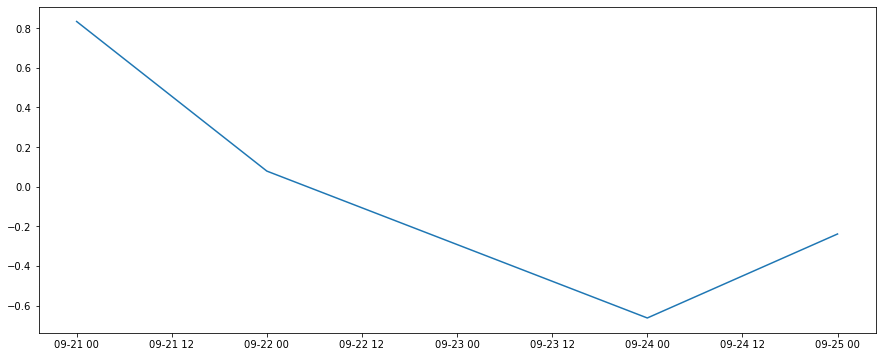

In [34]:
plt.figure(figsize=(15,6))
plt.plot(df_agg.index, df_agg['average_sentiment'])